In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.7/871.7 kB 19.1 MB/s eta 0:00:00


In [2]:
from zipfile import ZipFile
import os
import shutil

from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow

from ultralytics import YOLO


In [3]:
!mkdir ~/.kaggle

In [4]:
! cp /content/kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d gauravsanwal/indian-licence-plate

Dataset URL: https://www.kaggle.com/datasets/gauravsanwal/indian-licence-plate
License(s): unknown
 94% 345M/368M [00:07<00:00, 63.5MB/s]
100% 368M/368M [00:07<00:00, 54.3MB/s]


In [7]:
# Put on the same directory

# specifying the name of the zip file
file = "/content/indian-licence-plate.zip"

# open the zip file in read mode
with ZipFile(file, 'r') as zip:
    # list all the contents of the zip file
    zip.printdir()

    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

Streaming output truncated to the last 5000 lines.
licence plate.v1i.darknet/train/CarLongPlateGen1989_jpg.rf.c117b78b8dd910b8fdeb0ba8a40a0a18.txt 2022-09-08 07:06:28           69
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.019380eaa5c6b743e9eb92280512a8e8.jpg 2022-09-08 07:06:28        62642
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.019380eaa5c6b743e9eb92280512a8e8.txt 2022-09-08 07:06:30           80
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.831a2091bdfc35d8f12b2e486a6b389c.jpg 2022-09-08 07:06:30        54165
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.831a2091bdfc35d8f12b2e486a6b389c.txt 2022-09-08 07:06:30           80
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.a760671ae8f9e92493312b02e681e454.jpg 2022-09-08 07:06:30        54619
licence plate.v1i.darknet/train/CarLongPlateGen198_jpg.rf.a760671ae8f9e92493312b02e681e454.txt 2022-09-08 07:06:30           80
licence plate.v1i.darknet/train/CarLongPlateGen1990_

In [8]:
def move_files_to_folder(train_folder):
      # Paths (update these with the correct path to your train folder)

      images_folder = os.path.join(train_folder, 'images')  # Path to the images folder
      labels_folder = os.path.join(train_folder, 'labels')  # Path to the labels folder

      # Ensure the destination folders exist
      os.makedirs(images_folder, exist_ok=True)
      os.makedirs(labels_folder, exist_ok=True)

      # Loop through files in the train folder
      for filename in os.listdir(train_folder):
          file_path = os.path.join(train_folder, filename)

          # Check if it's a file (not a folder)
          if os.path.isfile(file_path):
              # If it's an image, move it to the images folder
              if filename.lower().endswith('.jpg'):
                  shutil.move(file_path, os.path.join(images_folder, filename))
              # If it's a label, move it to the labels folder
              elif filename.lower().endswith('.txt'):
                  shutil.move(file_path, os.path.join(labels_folder, filename))

      print("Images and labels have been separated into respective folders!")


In [9]:
move_files_to_folder('/content/licence_plate/train' )
move_files_to_folder('/content/licence_plate/test' )


Images and labels have been separated into respective folders!
Images and labels have been separated into respective folders!


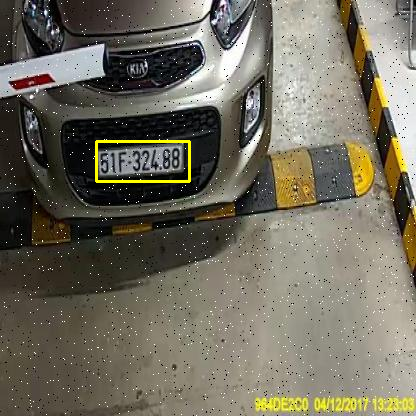

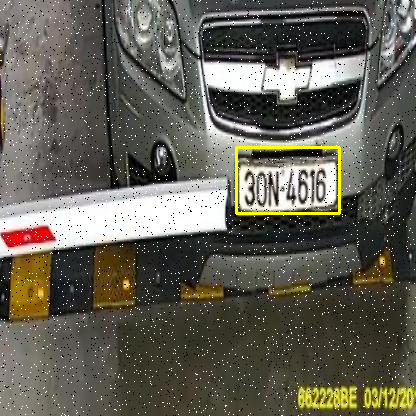

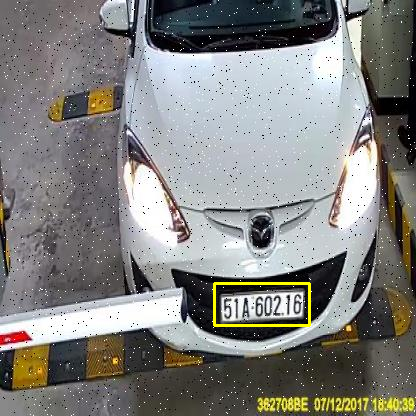

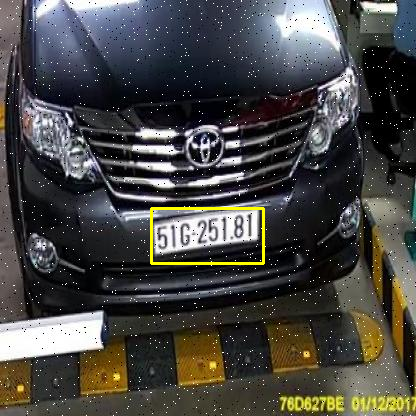

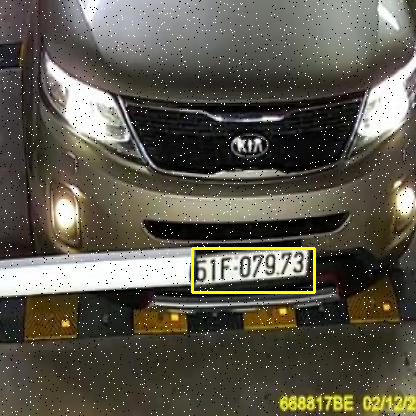

In [10]:

# Path to the training data
train_vichels_folder = '/content/licence_plate/train/images'
train_labels_folder = '/content/licence_plate/train/labels'

# List all files in the training vichels folder
train_vichels_files = os.listdir(train_vichels_folder)

# Select a sample file (for example, the first one)
sample_files = train_vichels_files[:5]

for sample_file in sample_files:
    # Load the image
    image_path = os.path.join(train_vichels_folder, sample_file)
    image = cv2.imread(image_path)

    # Get image dimensions
    height, width, _ = image.shape

    # Load the corresponding label
    label_file = sample_file.replace('.jpg', '.txt').replace('.JPG', '.txt')
    label_path = os.path.join(train_labels_folder, label_file)

    # Read the label content and draw bounding boxes
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Assuming label format: class_id x_center y_center width height (normalized values)
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center, y_center, box_width, box_height = map(float, parts[1:])

            # Convert normalized coordinates to absolute coordinates
            x_center_abs = int(x_center * width)
            y_center_abs = int(y_center * height)
            box_width_abs = int(box_width * width)
            box_height_abs = int(box_height * height)

            # Calculate the top-left and bottom-right coordinates of the bounding box
            x1 = int(x_center_abs - box_width_abs / 2)
            y1 = int(y_center_abs - box_height_abs / 2)
            x2 = int(x_center_abs + box_width_abs / 2)
            y2 = int(y_center_abs + box_height_abs / 2)

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

            # Add the label text near the bounding box
            #label_text = f'Class {class_id}'
            #cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Display the image with the bounding box and label using cv2_imshow
    cv2_imshow(image)


In [12]:

# Load YOLOv10n model from scratch
model = YOLO("yolov8n.yaml")

# Train the model
model.train(data="/content/licence_plate_recognition.yaml", epochs=75, imgsz=640)

Ultralytics YOLOv8.2.89 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/licence_plate_recognition.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

100%|██████████| 6.25M/6.25M [00:00<00:00, 109MB/s]


AMP: checks passed ✅


train: Scanning /content/licence_plate/train/labels... 7502 images, 1 backgrounds, 0 corrupt: 100%|██████████| 7503/7503 [00:03<00:00, 1910.04it/s]


train: New cache created: /content/licence_plate/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/licence_plate/test/labels... 918 images, 0 backgrounds, 0 corrupt: 100%|██████████| 918/918 [00:00<00:00, 1299.83it/s]

val: New cache created: /content/licence_plate/test/labels.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      2.29G      2.476      2.735      2.763         27        640: 100%|██████████| 469/469 [02:40<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.45it/s]

                   all        918        959      0.762      0.627      0.711      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      2.14G      1.527      1.012      1.671         20        640: 100%|██████████| 469/469 [02:31<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]

                   all        918        959      0.846      0.614      0.755      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      2.16G       1.42     0.8485      1.565         23        640: 100%|██████████| 469/469 [02:33<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.08it/s]

                   all        918        959      0.856       0.76      0.846      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      2.14G      1.373     0.7937      1.528         20        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.20it/s]

                   all        918        959      0.876      0.765      0.845       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      2.14G       1.31     0.7472      1.474         24        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.02it/s]

                   all        918        959      0.888        0.8       0.87      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      2.14G      1.237     0.6931      1.419         33        640: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]

                   all        918        959      0.915      0.794      0.872      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      2.14G      1.196     0.6639      1.383         28        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.91it/s]

                   all        918        959      0.924      0.814      0.878       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      2.14G      1.157     0.6287      1.356         24        640: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.25it/s]

                   all        918        959      0.933      0.783      0.865      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      2.14G      1.127     0.6172       1.34         24        640: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.11it/s]

                   all        918        959      0.938       0.83      0.897      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      2.14G        1.1     0.5933      1.316         26        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.91it/s]

                   all        918        959      0.912      0.755      0.868      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      2.14G      1.068     0.5775      1.294         24        640: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.51it/s]

                   all        918        959      0.945      0.853      0.912      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      2.14G      1.061     0.5716      1.299         19        640: 100%|██████████| 469/469 [02:28<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]

                   all        918        959       0.96      0.826      0.889      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      2.14G      1.045     0.5622      1.283         20        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.12it/s]

                   all        918        959      0.954      0.851      0.911       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      2.14G      1.014     0.5434      1.261         21        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.21it/s]

                   all        918        959      0.928      0.832       0.89      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      2.14G      1.009     0.5407      1.251         27        640: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.14it/s]


                   all        918        959      0.964       0.85       0.91      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      2.14G     0.9845     0.5213      1.242         24        640: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]


                   all        918        959      0.961      0.881      0.931      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      2.14G     0.9901     0.5248       1.24         23        640: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.67it/s]

                   all        918        959      0.943      0.857      0.914      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      2.14G     0.9683     0.5139      1.228         34        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]

                   all        918        959      0.938      0.835      0.904      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      2.14G     0.9542     0.5034      1.216         16        640: 100%|██████████| 469/469 [02:27<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.95it/s]

                   all        918        959      0.957      0.854      0.913      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      2.15G     0.9427      0.499      1.214         16        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.79it/s]

                   all        918        959      0.959       0.87       0.92      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      2.14G     0.9273     0.4874      1.204         23        640: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.05it/s]

                   all        918        959      0.931      0.857      0.918      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      2.14G     0.9216     0.4793        1.2         22        640: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.97it/s]

                   all        918        959      0.949      0.853      0.912      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      2.14G     0.9201     0.4828      1.194         20        640: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.00it/s]

                   all        918        959      0.958       0.85      0.921      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      2.14G     0.8994     0.4727      1.178         24        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]

                   all        918        959       0.94      0.869      0.925      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      2.14G     0.8983     0.4639      1.182         15        640: 100%|██████████| 469/469 [02:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]

                   all        918        959      0.948      0.882      0.928      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      2.14G     0.8953     0.4693      1.176         27        640: 100%|██████████| 469/469 [02:32<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.86it/s]

                   all        918        959      0.936       0.87      0.921      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      2.14G     0.8929     0.4648      1.176         22        640: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]

                   all        918        959      0.933      0.868      0.922        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      2.14G     0.8758      0.456      1.165         31        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.40it/s]

                   all        918        959      0.939      0.873      0.922      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      2.14G     0.8632     0.4448      1.157         31        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.85it/s]

                   all        918        959       0.95      0.897      0.936      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      2.14G     0.8632     0.4511      1.151         17        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]

                   all        918        959      0.949      0.886      0.935       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      2.14G     0.8591     0.4395      1.155         23        640: 100%|██████████| 469/469 [02:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]

                   all        918        959      0.939      0.897      0.933      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      2.14G     0.8501     0.4368      1.152         22        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.72it/s]

                   all        918        959      0.958      0.887      0.932      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      2.14G     0.8386     0.4297      1.148         27        640: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]

                   all        918        959      0.961      0.878      0.928      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      2.15G     0.8332     0.4253      1.141         33        640: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.97it/s]

                   all        918        959       0.95      0.881      0.931      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      2.14G     0.8405     0.4251      1.136         25        640: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918        959      0.936      0.875      0.925      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      2.14G      0.826     0.4216      1.131         20        640: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]

                   all        918        959      0.962      0.876      0.931      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      2.14G     0.8242     0.4223       1.13         29        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.92it/s]

                   all        918        959      0.969      0.887      0.938      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      2.14G     0.8154     0.4133       1.12         25        640: 100%|██████████| 469/469 [02:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]

                   all        918        959      0.949      0.897      0.937      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      2.14G     0.8103     0.4081      1.119         18        640: 100%|██████████| 469/469 [02:26<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.01it/s]

                   all        918        959       0.96      0.873      0.925        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      2.14G     0.8035     0.4078      1.122         17        640: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.90it/s]

                   all        918        959      0.943      0.882      0.921       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      2.14G     0.8074     0.4057      1.117         26        640: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all        918        959      0.975      0.875      0.934      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      2.14G     0.7924     0.4045      1.114         14        640: 100%|██████████| 469/469 [02:26<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]

                   all        918        959      0.974      0.881       0.93      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      2.14G     0.7962     0.4052       1.11         25        640: 100%|██████████| 469/469 [02:29<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.47it/s]

                   all        918        959      0.953        0.9      0.935        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      2.14G     0.7892     0.3933      1.111         26        640: 100%|██████████| 469/469 [02:30<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]

                   all        918        959      0.962      0.891      0.935        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      2.14G     0.7834     0.3967      1.112         24        640: 100%|██████████| 469/469 [02:28<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.21it/s]

                   all        918        959      0.946      0.878       0.93      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      2.14G     0.7711      0.384        1.1         25        640: 100%|██████████| 469/469 [02:27<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]

                   all        918        959      0.958      0.883      0.934      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      2.14G     0.7782     0.3896       1.11         21        640: 100%|██████████| 469/469 [02:30<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.05it/s]

                   all        918        959      0.938      0.901      0.935      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      2.14G     0.7648     0.3817      1.096         25        640: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


                   all        918        959      0.932      0.876      0.929      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      2.14G       0.77     0.3829      1.101         22        640: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]

                   all        918        959      0.962      0.867       0.93      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      2.14G      0.758     0.3753      1.092         22        640: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]

                   all        918        959      0.963      0.888      0.939      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      2.14G     0.7599     0.3782      1.097         22        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.08it/s]

                   all        918        959      0.949      0.892      0.932       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      2.14G     0.7611      0.378      1.095         25        640: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]

                   all        918        959      0.943      0.907      0.936      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      2.14G     0.7457     0.3712       1.09         27        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.55it/s]

                   all        918        959      0.949      0.898      0.936      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      2.14G     0.7449     0.3692      1.089         18        640: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.10it/s]

                   all        918        959      0.943      0.908       0.94      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      2.14G     0.7408     0.3651      1.081         27        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.47it/s]

                   all        918        959      0.957      0.897      0.938      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      2.14G     0.7343     0.3653      1.081         22        640: 100%|██████████| 469/469 [02:29<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.95it/s]

                   all        918        959      0.956      0.891      0.932      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      2.14G     0.7458     0.3659      1.086         24        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]

                   all        918        959      0.965      0.899      0.937      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      2.14G      0.742     0.3634      1.079         29        640: 100%|██████████| 469/469 [02:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.55it/s]

                   all        918        959      0.955      0.902      0.938      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      2.14G      0.729     0.3581      1.069         26        640: 100%|██████████| 469/469 [02:28<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.28it/s]

                   all        918        959      0.965      0.882      0.935      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      2.14G     0.7239     0.3542      1.071         18        640: 100%|██████████| 469/469 [02:25<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]

                   all        918        959      0.957      0.895      0.935      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      2.14G     0.7202     0.3528       1.07         22        640: 100%|██████████| 469/469 [02:30<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:10<00:00,  2.75it/s]


                   all        918        959      0.967      0.886      0.937      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      2.14G     0.7159     0.3494      1.069         22        640: 100%|██████████| 469/469 [02:26<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.38it/s]

                   all        918        959      0.944      0.901      0.936        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      2.14G     0.7143     0.3485      1.068         18        640: 100%|██████████| 469/469 [02:31<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.74it/s]

                   all        918        959      0.957      0.897      0.938      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      2.14G     0.7087     0.3436       1.06         29        640: 100%|██████████| 469/469 [02:29<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.99it/s]


                   all        918        959      0.941      0.904      0.938      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      2.14G     0.7089     0.3447      1.061         24        640: 100%|██████████| 469/469 [02:27<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:07<00:00,  3.95it/s]

                   all        918        959      0.939      0.907      0.937      0.511


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      2.21G     0.6329      0.299      1.021         15        640: 100%|██████████| 469/469 [02:20<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.09it/s]

                   all        918        959      0.955      0.902      0.937      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      2.14G     0.6261     0.2949      1.016         17        640: 100%|██████████| 469/469 [02:25<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]

                   all        918        959      0.963      0.889      0.934      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      2.14G     0.6213     0.2899      1.008         14        640: 100%|██████████| 469/469 [02:21<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]

                   all        918        959      0.954      0.905      0.938      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      2.14G     0.6158     0.2892      1.014         15        640: 100%|██████████| 469/469 [02:22<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  2.96it/s]

                   all        918        959      0.953      0.909      0.938      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      2.14G     0.6115     0.2844      1.008         17        640: 100%|██████████| 469/469 [02:20<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:11<00:00,  2.63it/s]

                   all        918        959      0.956      0.898      0.937      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      2.14G     0.6102     0.2848      1.005         15        640: 100%|██████████| 469/469 [02:21<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.56it/s]

                   all        918        959       0.96      0.893      0.939      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      2.14G     0.5997     0.2783     0.9995         15        640: 100%|██████████| 469/469 [02:23<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]

                   all        918        959      0.962      0.889      0.937      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      2.14G     0.6028     0.2801      1.002         15        640: 100%|██████████| 469/469 [02:18<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.21it/s]

                   all        918        959      0.967      0.891      0.938      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      2.14G     0.5905      0.277      0.995         15        640: 100%|██████████| 469/469 [02:23<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:09<00:00,  3.05it/s]

                   all        918        959      0.971      0.888      0.938      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      2.14G     0.5935     0.2766     0.9939         14        640: 100%|██████████| 469/469 [02:20<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:08<00:00,  3.48it/s]

                   all        918        959      0.973      0.887      0.939      0.491



75 epochs completed in 3.272 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.89 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


                   all        918        959      0.939      0.897      0.933      0.522
Speed: 0.3ms preprocess, 2.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df10ccc2a10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [14]:
# Set the locale to UTF-8
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Zip the directory
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/train2/ (stored 0%)
  adding: content/runs/detect/train2/val_batch1_pred.jpg (deflated 13%)
  adding: content/runs/detect/train2/args.yaml (deflated 52%)
  adding: content/runs/detect/train2/results.csv (deflated 85%)
  adding: content/runs/detect/train2/events.out.tfevents.1725667869.5a8daa3fbdd2.4220.0 (deflated 88%)
  adding: content/runs/detect/train2/PR_curve.png (deflated 23%)
  adding: content/runs/detect/train2/val_batch1_labels.jpg (deflated 13%)
  adding: content/runs/detect/train2/val_batch2_labels.jpg (deflated 9%)
  adding: content/runs/detect/train2/R_curve.png (deflated 19%)
  adding: content/runs/detect/train2/labels_correlogram.jpg (deflated 36%)
  adding: content/runs/detect/train2/train_batch30485.jpg (deflated 4%)
  adding: content/runs/detect/train2/train_batch1.jpg (deflated 1%)
  adding: content/runs/detect/train2/val_batch2_pred.jpg (deflated 8%)
  adding

In [15]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>